In [29]:
import csv
import pandas as pd
import sklearn.model_selection as skm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
data = pd.read_csv('yelp_labelled.txt', header=None, sep='\t')
data.head(5)

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [31]:
X_text = data[0]
y = data[1]
X_train, X_test, y_train, y_test = skm.train_test_split(X_text, y, test_size=0.2, stratify=y, random_state=0)
X_text_train, X_validation, y_text_train, y_validation = skm.train_test_split(X_train, y_train, test_size=0.125, stratify=y_train, random_state=0)

In [32]:
import stanza

nlp = stanza.Pipeline(lang='en', processors='tokenize,lemma', tokenize_no_ssplit=True)

2024-11-08 23:54:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-11-08 23:54:18 INFO: Downloaded file to C:\Users\DhM\stanza_resources\resources.json
2024-11-08 23:54:18 WARNING: Language en package default expects mwt, which has been added
2024-11-08 23:54:18 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| lemma     | combined_nocharlm |

2024-11-08 23:54:18 INFO: Using device: cpu
2024-11-08 23:54:18 INFO: Loading: tokenize
c:\Users\DhM\anaconda3\envs\condaenv\Lib\site-packages\stanza\models\tokenization\trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct 

In [33]:
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([word.lemma for sentence in doc.sentences for word in sentence.words])

data['lemmatized_text'] = data[0].apply(lemmatize_text)
X_text_lemmatized = data['lemmatized_text']
X_train_lem, X_test_lem, y_train, y_test = skm.train_test_split(X_text_lemmatized, y, test_size=0.2, stratify=y, random_state=0)
X_text_train_lem, X_validation_lem, y_train_lem, y_validation_lem = skm.train_test_split(X_train_lem, y_train, test_size=0.125, stratify=y_train, random_state=0)


In [34]:
vectorizer_params = {
    'min_df': [1, 2, 3, 4, 5],
    'stop_words': ['english', None],
    'binary': [True, False],
    'lowercase': [True, False]
}
results = []

# Testing all parameters in one big loop

In [ ]:
results = []

for use_lemmatized in [False, True]:
    X_train_text = X_text_train_lem if use_lemmatized else X_text_train
    X_validation_text = X_validation_lem if use_lemmatized else X_validation
    y_train = y_train_lem if use_lemmatized else y_text_train
    y_validation = y_validation_lem if use_lemmatized else y_validation
    dataset_type = "Lemmatized" if use_lemmatized else "Non-Lemmatized"
    
    for vectorizer_class in [CountVectorizer, TfidfVectorizer]:
        for min_df in vectorizer_params['min_df']:
            for stop_words in vectorizer_params['stop_words']:
                for binary in vectorizer_params['binary']:
                    for lowercase in vectorizer_params['lowercase']:

                        vectorizer = vectorizer_class(min_df=min_df, stop_words=stop_words, binary=binary, lowercase=lowercase)
                        
                        X_train = vectorizer.fit_transform(X_train_text)
                        X_val = vectorizer.transform(X_validation_text)

                        for alpha in [0.1, 0.4, 0.8, 1.3, 2]:
                            nb_classifier = MultinomialNB(alpha=alpha)
                            nb_classifier.fit(X_train, y_train)
                            y_pred = nb_classifier.predict(X_val)
                            accuracy = accuracy_score(y_validation, y_pred)

                            results.append({
                                'Dataset': dataset_type,
                                'Vectorizer': vectorizer_class.__name__,
                                'min_df': min_df,
                                'stop_words': stop_words,
                                'binary': binary,
                                'lowercase': lowercase,
                                'Classifier': 'MultinomialNB',
                                'alpha': alpha,
                                'Validation Accuracy': accuracy
                            })

                        for C in [0.1, 0.4, 0.8, 1.3, 2]:
                            svm_classifier = SVC(kernel='linear', C=C)
                            svm_classifier.fit(X_train, y_train)
                            y_pred_svm = svm_classifier.predict(X_val)
                            accuracy_svm = accuracy_score(y_validation, y_pred_svm)

                            results.append({
                                'Dataset': dataset_type,
                                'Vectorizer': vectorizer_class.__name__,
                                'min_df': min_df,
                                'stop_words': stop_words,
                                'binary': binary,
                                'lowercase': lowercase,
                                'Classifier': 'SVC',
                                'C': C,
                                'Validation Accuracy': accuracy_svm
                            })

results_df = pd.DataFrame(results)


# Data visualization

<Figure size 1600x1200 with 0 Axes>

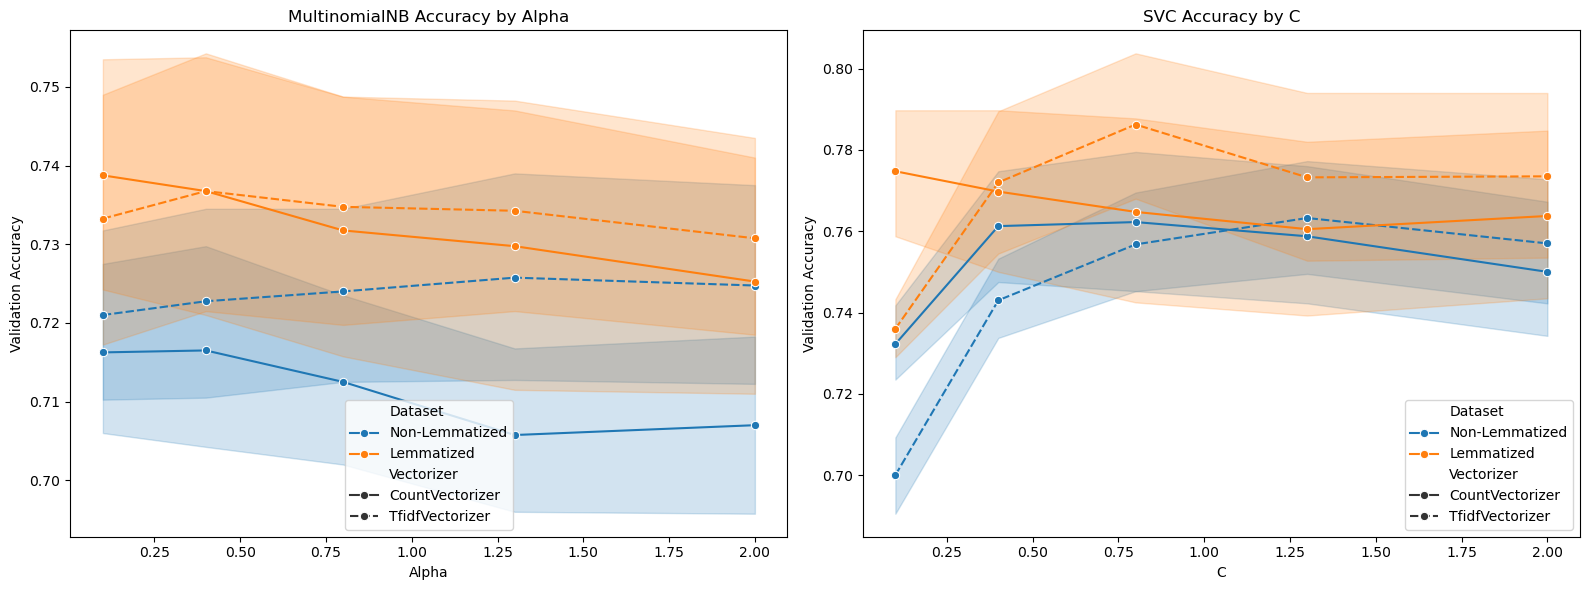

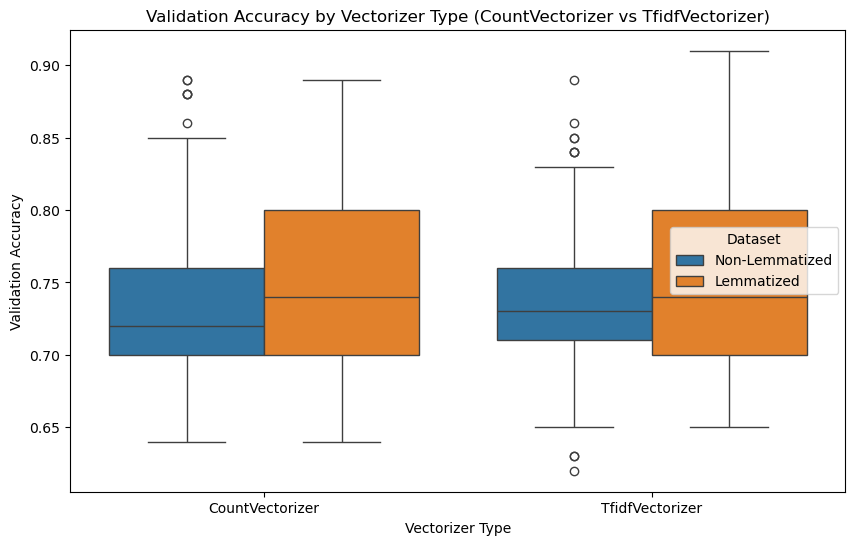

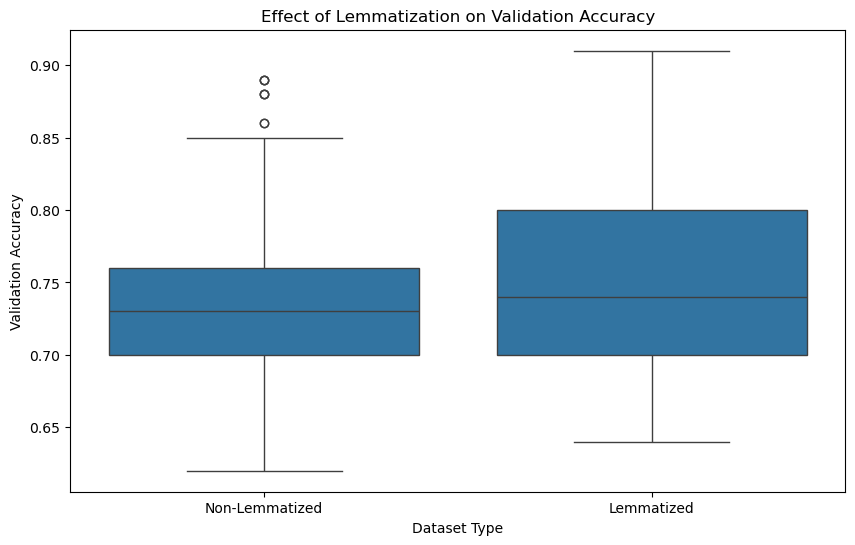

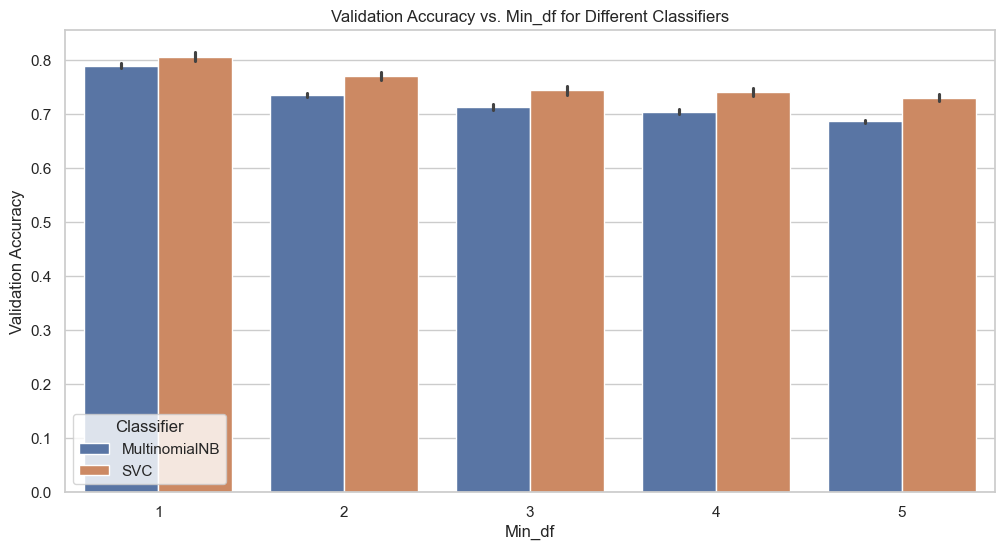

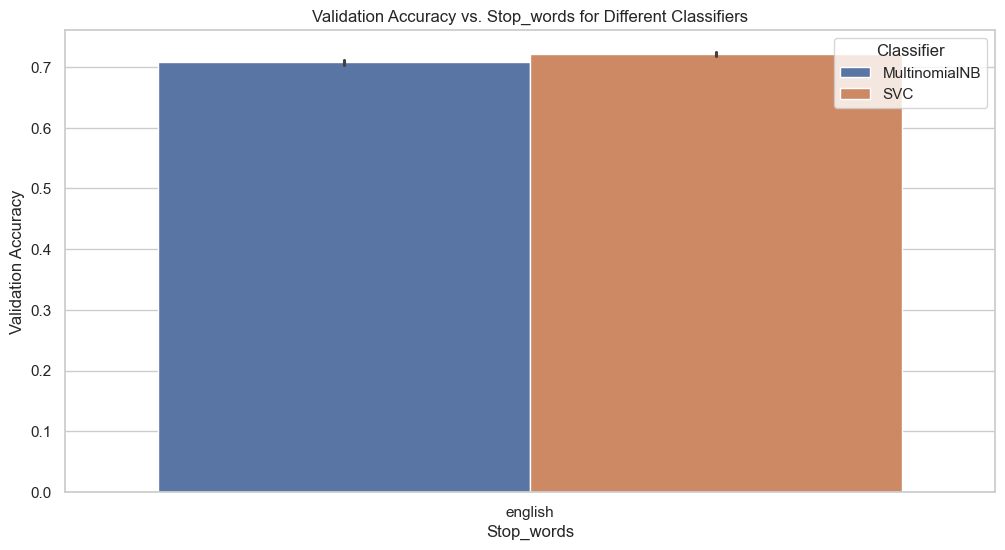

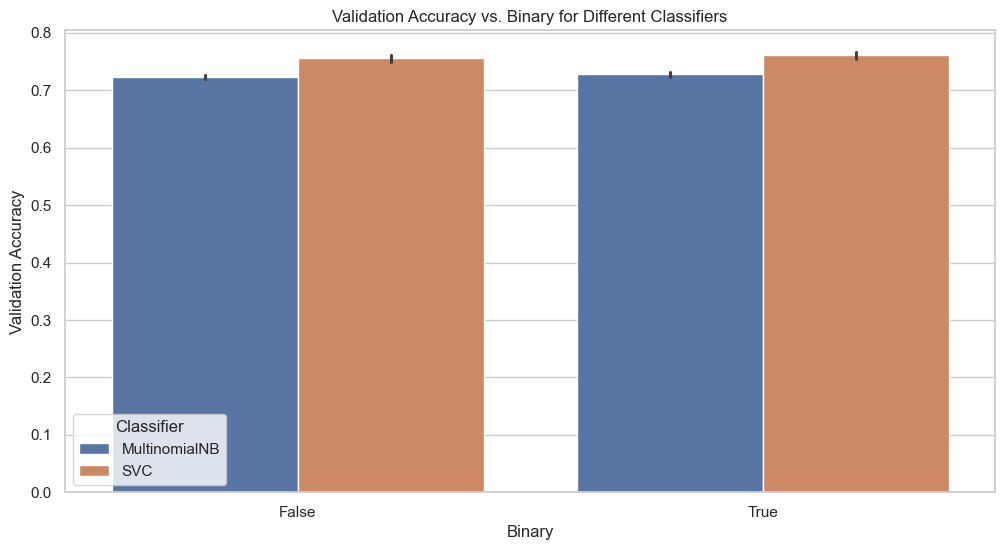

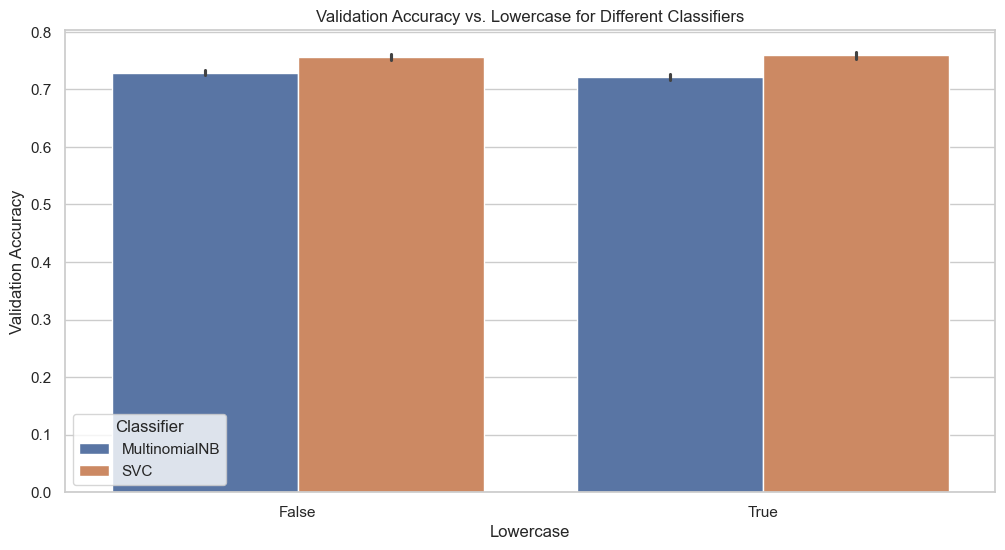

In [36]:
plt.figure(figsize=(16, 12))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

nb_results = results_df[results_df['Classifier'] == 'MultinomialNB']
svc_results = results_df[results_df['Classifier'] == 'SVC']

sns.lineplot(data=nb_results, x='alpha', y='Validation Accuracy', hue='Dataset', style='Vectorizer', marker='o', ax=axes[0])
axes[0].set_title('MultinomialNB Accuracy by Alpha')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Validation Accuracy')

sns.lineplot(data=svc_results, x='C', y='Validation Accuracy', hue='Dataset', style='Vectorizer', marker='o', ax=axes[1])
axes[1].set_title('SVC Accuracy by C')
axes[1].set_xlabel('C')
axes[1].set_ylabel('Validation Accuracy')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='Vectorizer', y='Validation Accuracy', hue='Dataset')
plt.title('Validation Accuracy by Vectorizer Type (CountVectorizer vs TfidfVectorizer)')
plt.xlabel('Vectorizer Type')
plt.ylabel('Validation Accuracy')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='Dataset', y='Validation Accuracy')
plt.title('Effect of Lemmatization on Validation Accuracy')
plt.xlabel('Dataset Type')
plt.ylabel('Validation Accuracy')
plt.show()

sns.set(style="whitegrid")

def plot_vectorizer_params_against_accuracy(df, parameter):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x=parameter, y='Validation Accuracy', hue='Classifier')
    plt.title(f'Validation Accuracy vs. {parameter.capitalize()} for Different Classifiers')
    plt.ylabel('Validation Accuracy')
    plt.xlabel(parameter.capitalize())
    plt.legend(title='Classifier')
    plt.show()

for param in ['min_df', 'stop_words', 'binary', 'lowercase']:
    plot_vectorizer_params_against_accuracy(results_df, param)

#### As you can see, best min_df is 1
#### best lowercase is TRUE
#### best binary is TRUE
#### stop_words = english
#### For both vectorizers

#### Lemmatized dataset is better based on validation accuracy 
#### Count vectorizer performs better on both datasets too
#### Best parameters for classifiers are:
#### Naiive bayes
#### 0.4 alpha for non lemmatized count and tfidf 
#### 1.3 alpha for lemmatized count 
#### 2 alpha for lemmatized tfidf
#### SVC
#### 0.4 C for lemmatized count
#### 1.3 C for lemmatized tfidf
#### 0.4 C for non lemmatized count and tfidf

# Evaluation of all tested configurations:

In [37]:
X_text = data[0]
y = data[1]
X_train, X_test, y_train, y_test = skm.train_test_split(X_text, y, test_size=0.2, stratify=y, random_state=0)
X_text_train, X_validation_text, y_text_train, y_validation = skm.train_test_split(X_text, y, test_size=0.125, stratify=y, random_state=0)

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([word.lemma for sentence in doc.sentences for word in sentence.words])

data['lemmatized_text'] = data[0].apply(lemmatize_text)
X_text_lemmatized = data['lemmatized_text']

X_train_lem, X_test_lem, _, _ = skm.train_test_split(X_text_lemmatized, y, test_size=0.2, stratify=y, random_state=0)
X_text_train_lem, X_validation_lem, _, _ = skm.train_test_split(X_text_lemmatized, y, test_size=0.125, stratify=y, random_state=0)

vectorizer_params = {
    "lowercase": True,
    "binary": True,
    "stop_words": "english",
    "min_df": 1
}

tfidf_vectorizer = TfidfVectorizer(**vectorizer_params)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

nb_tfidf = MultinomialNB(alpha=0.4)
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)
print("Non-Lemmatized - Tfidf + MultinomialNB Accuracy:", accuracy_score(y_test, y_pred_nb_tfidf))

svc_tfidf = SVC(kernel='linear', C=0.4)
svc_tfidf.fit(X_train_tfidf, y_train)
y_pred_svc_tfidf = svc_tfidf.predict(X_test_tfidf)
print("Non-Lemmatized - Tfidf + SVC Accuracy:", accuracy_score(y_test, y_pred_svc_tfidf))

count_vectorizer = CountVectorizer(**vectorizer_params)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

nb_count = MultinomialNB(alpha=0.4)
nb_count.fit(X_train_count, y_train)
y_pred_nb_count = nb_count.predict(X_test_count)
print("Non-Lemmatized - Count + MultinomialNB Accuracy:", accuracy_score(y_test, y_pred_nb_count))

svc_count = SVC(kernel='linear', C=0.4)
svc_count.fit(X_train_count, y_train)
y_pred_svc_count = svc_count.predict(X_test_count)
print("Non-Lemmatized - Count + SVC Accuracy:", accuracy_score(y_test, y_pred_svc_count))

tfidf_vectorizer_lem = TfidfVectorizer(**vectorizer_params)
X_train_tfidf_lem = tfidf_vectorizer_lem.fit_transform(X_train_lem)
X_test_tfidf_lem = tfidf_vectorizer_lem.transform(X_test_lem)

nb_tfidf_lem = MultinomialNB(alpha=2)
nb_tfidf_lem.fit(X_train_tfidf_lem, y_train)
y_pred_nb_tfidf_lem = nb_tfidf_lem.predict(X_test_tfidf_lem)
print("Lemmatized - Tfidf + MultinomialNB Accuracy:", accuracy_score(y_test, y_pred_nb_tfidf_lem))

svc_tfidf_lem = SVC(kernel='linear', C=1.3)
svc_tfidf_lem.fit(X_train_tfidf_lem, y_train)
y_pred_svc_tfidf_lem = svc_tfidf_lem.predict(X_test_tfidf_lem)
print("Lemmatized - Tfidf + SVC Accuracy:", accuracy_score(y_test, y_pred_svc_tfidf_lem))

count_vectorizer_lem = CountVectorizer(**vectorizer_params)
X_train_count_lem = count_vectorizer_lem.fit_transform(X_train_lem)
X_test_count_lem = count_vectorizer_lem.transform(X_test_lem)

nb_count_lem = MultinomialNB(alpha=1.3)
nb_count_lem.fit(X_train_count_lem, y_train)
y_pred_nb_count_lem = nb_count_lem.predict(X_test_count_lem)
print("Lemmatized - Count + MultinomialNB Accuracy:", accuracy_score(y_test, y_pred_nb_count_lem))

svc_count_lem = SVC(kernel='linear', C=0.4)
svc_count_lem.fit(X_train_count_lem, y_train)
y_pred_svc_count_lem = svc_count_lem.predict(X_test_count_lem)
print("Lemmatized - Count + SVC Accuracy:", accuracy_score(y_test, y_pred_svc_count_lem))

Non-Lemmatized - Tfidf + MultinomialNB Accuracy: 0.81
Non-Lemmatized - Tfidf + SVC Accuracy: 0.805
Non-Lemmatized - Count + MultinomialNB Accuracy: 0.81
Non-Lemmatized - Count + SVC Accuracy: 0.815
Lemmatized - Tfidf + MultinomialNB Accuracy: 0.79
Lemmatized - Tfidf + SVC Accuracy: 0.77
Lemmatized - Count + MultinomialNB Accuracy: 0.8
Lemmatized - Count + SVC Accuracy: 0.8


#### testing on unified parameters for both vectorizers, the best model is count vectorizer and svc classifier with non lemmatized dataset
#### Strangely, non-lemmatized dataset performed much better than lemmatized dataset, despite the results shown in validation 